In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


<a id='step1'></a>
## Step 1: Import Dataset and Libraries

Our fist step is to import all the libraries used in this project.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from glob import glob
import pandas as pd
import os
import re
import random 
from PIL import Image 
from sklearn.preprocessing import LabelEncoder
import os
import pandas as pd
from skimage import io
import torch
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torchvision.transforms as transforms  # Transformations we can perform on our dataset
import torchvision
from torch.utils.data import (Dataset, DataLoader)  # Gives easier dataset managment and creates mini batches
from torchvision.datasets import ImageFolder
import torchvision.models as models

In [ ]:
animals_list = os.listdir("/content/gdrive/My Drive/oregon_wildlife")
animals_file_list = []

for i in range(len(animals_list)):

  animals_file_list.append(os.listdir(str("/content/gdrive/My Drive/oregon_wildlife/" + animals_list[i])))  
  n = len(animals_file_list[i])
  print('There are', n , animals_list[i] , 'images.')

There are 660 elk images.
There are 696 bobcat images.
There are 686 cougar images.
There are 748 bald_eagle images.
There are 717 canada_lynx images.
There are 668 gray_fox images.
There are 736 coyote images.
There are 735 columbian_black-tailed_deer images.
There are 718 black_bear images.
There are 764 deer images.
There are 577 mountain_beaver images.
There are 728 virginia_opossum images.
There are 726 sea_lions images.
There are 701 nutria images.
There are 759 red_fox images.
There are 728 raccoon images.
There are 656 raven images.
There are 698 seals images.
There are 730 gray_wolf images.
There are 588 ringtail images.


Apparently we have a balanced dataset,  which means we have a similar 9but not equal) proportion of images of animals from each species. 
To have a more real notion let's visualize the animals.






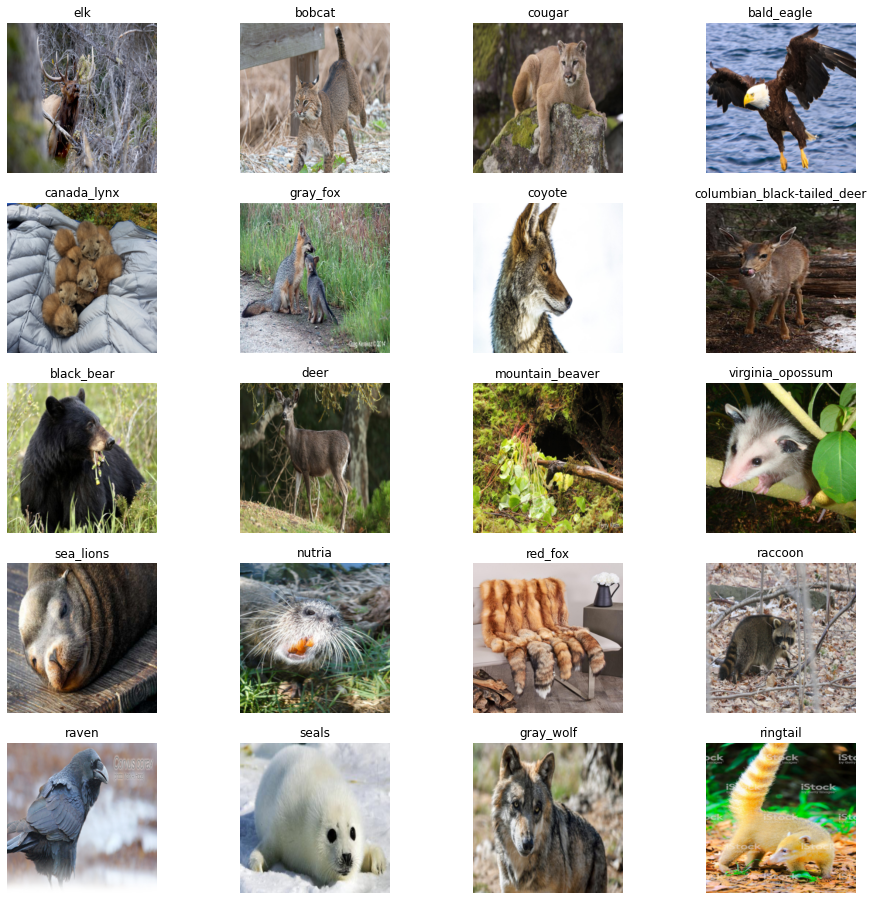

In [ ]:
w=10
h=10
fig=plt.figure(figsize=(16, 16))
columns = 4
rows = 5

for i in range(1, len(animals_list)+1):
    img = mpimg.imread(str("/content/gdrive/My Drive/oregon_wildlife/"+ animals_list[i-1] + "/"+ animals_file_list[i-1][0]))
    compose = transforms.Compose([transforms.ToPILImage(),transforms.Resize((256,256))])
    img = compose(img)
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.title(animals_list[i-1])
    plt.imshow(img)
plt.show()

## Load Data

Now we will make use of Pytorch elements `transform`, `ImageFolder`, `DataLoader` to load the data. 

The next steps will be the following. 

1. Create a dataframe with the name of each file, the animal and the absolute path. 
2. Select files that will further be in the train, test and validation sets. 
3. Perform transformation in the data such as reshaping, croping and rotation that will allow the images that are from different sizes to be analyzed together. 
4. Load the datasets using the DataLoader function, that will transform the images in tensors that will be analysed by the CNN.

In [ ]:
dir = '/content/gdrive/My Drive/oregon_wildlife'
files = [f for f in glob(dir + "**/**", recursive=True)] # create a list will allabsolute path of all files

In [ ]:
df_animals = pd.DataFrame({"file_path":files}) # transform in a dataframe
df_animals['animal'] = df_animals['file_path'].str.extract('/oregon_wildlife/(.+)/') # extract the name of the animal
df_animals['file'] = df_animals['file_path'].str.extract('oregon_wildlife/.+/(.+)') # extrat the file name
df_animals = df_animals.dropna() # drop nas  

Now we split the data in train, test and validation (inside the dataframe). 

In [ ]:
animal_set = set(df_animals['animal'])
train_val_test_list = [0,1,2]
train_val_weights = [70,15,15]
df_animals['train_val_test'] = 'NA' 

for an in animal_set:
  n = sum(df_animals['animal'] == an) # count the number of animals
  train_val_test = random.choices(train_val_test_list, weights= train_val_weights,  k=n)
  df_animals.loc[df_animals['animal'] == an, 'train_val_test'] = train_val_test 

Now we will create the dictonary `transform`. it will be used to transform the train, test and validation datasets. 
We will apply different transformations on the train and test/validation datasets. Data augmentation is used in the trainning dataset to avoid overfitting, that means to avoid the a very good performance on the trainning set but a bed performane on the validation and testing datasets (bed generalization). The methods used were:
- Flipping the images horizontally 
- Random Cropping: Extract randomly a 224 × 224 pixels section from 256 × 256 pixels
- RandomRotation: Randomly rotate the image by 10 degrees.


In [ ]:
transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),    
}


We create an auxiliary function to make sure the data is correctly splited among train, test and validation.   

In [ ]:
def check_train(path):
    return (df_animals[df_animals['file_path'] == path].train_val_test == 0).bool

def check_valid(path):
    return (df_animals[df_animals['file_path'] == path].train_val_test == 1).bool

def check_test(path):
    return (df_animals[df_animals['file_path'] == path].train_val_test == 2).bool

#### Load the dataset

In [ ]:
# Reading Dataset
image_datasets = {
    'train' : ImageFolder(root= dir, transform=transform['train'], is_valid_file=check_train),
    'valid' : ImageFolder(root=dir, transform=transform['valid'], is_valid_file=check_valid),
    'test' : ImageFolder(root=dir, transform=transform['test'], is_valid_file=check_test)
}

In [ ]:
num_workers = 0
batch_size = 20

loaders_scratch = {
    'train' : DataLoader(image_datasets['train'], shuffle = True, batch_size = batch_size),
    'valid' : DataLoader(image_datasets['valid'], shuffle = True, batch_size = batch_size),
    'test' : DataLoader(image_datasets['test'], shuffle = True, batch_size = batch_size)    
}

#### USE GPU

In [ ]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()

<a id='step2'></a>
## Step 2: Create a CNN to Classify Wild Animals (from Scratch)

We create a CNN that reveives tensors of `224 x 224 x 3` dimensions (that's how we prepared the dataset). 

Some of the elements of our network built from scratch. 
- Five convolutional layers. The last will return a tensor of `128 x 256, x 3` dimensions. Padding equals 1. 
- A relu function applied after every convolutional iteration.
- A pooling function applied after every convolutional iteration.
- Two dropout layers to avoid overffiting.
- Two fully connected layers.  




 that will transform `128 x 256 x 3`
- relu


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 224 x 224 x 3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 122 x 122 x 16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 56 x 56 x 32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # convolutional layer (sees 28 x 28 x 64 tensor)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        # convolutional layer (sees 14 x 14 x 128 tensor)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

        self.conv_bn1 = nn.BatchNorm2d(224,3)
        self.conv_bn2 = nn.BatchNorm2d(16)
        self.conv_bn3 = nn.BatchNorm2d(32)
        self.conv_bn4 = nn.BatchNorm2d(64)
        self.conv_bn5 = nn.BatchNorm2d(128)
        self.conv_bn6 = nn.BatchNorm2d(256)

        # linear layer (64 * 4 * 4 -> 133)
        self.fc1 = nn.Linear(256 * 7 * 7, 512)
        # linear layer (133 -> 133)
        self.fc2 = nn.Linear(512, 20)
        

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.conv_bn2(self.pool(F.relu(self.conv1(x))))
        x = self.conv_bn3(self.pool(F.relu(self.conv2(x))))
        x = self.conv_bn4(self.pool(F.relu(self.conv3(x))))
        x = self.conv_bn5(self.pool(F.relu(self.conv4(x))))
        x = self.conv_bn6(self.pool(F.relu(self.conv5(x))))
        # flatten image input
        x = x.view(-1, 256 * 7 * 7)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()
print(model_scratch)

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (conv_bn1): BatchNorm2d(224, eps=3, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn6

In [ ]:

# specify loss function
criterion_scratch = nn.CrossEntropyLoss()

# specify optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.001, momentum=0.9)

In [ ]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):

    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            ## record the average training loss, using something like
            train_loss = train_loss + (1 / (batch_idx + 1)) * (loss.data - train_loss)

            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss = valid_loss + (1 / (batch_idx + 1)) * (loss.data - valid_loss)

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), '/content/gdrive/My Drive/model_scratch.pt')
            valid_loss_min = valid_loss
            
    # return trained model
    return model

# train the model
model_scratch = train(25, loaders_scratch, model_scratch, optimizer_scratch, criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('/content/gdrive/My Drive/model_scratch.pt'))

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch: 1 	Training Loss: 2.607074 	Validation Loss: 2.116710
Validation loss decreased (inf --> 2.116710).  Saving model ...
Epoch: 2 	Training Loss: 2.354062 	Validation Loss: 1.838744
Validation loss decreased (2.116710 --> 1.838744).  Saving model ...
Epoch: 3 	Training Loss: 2.214730 	Validation Loss: 1.714859
Validation loss decreased (1.838744 --> 1.714859).  Saving model ...
Epoch: 4 	Training Loss: 2.126942 	Validation Loss: 1.554157
Validation loss decreased (1.714859 --> 1.554157).  Saving model ...
Epoch: 5 	Training Loss: 2.070691 	Validation Loss: 1.541050
Validation loss decreased (1.554157 --> 1.541050).  Saving model ...
Epoch: 6 	Training Loss: 1.990526 	Validation Loss: 1.407331
Validation loss decreased (1.541050 --> 1.407331).  Saving model ...
Epoch: 7 	Training Loss: 1.929990 	Validation Loss: 1.316320
Validation loss decreased (1.407331 --> 1.316320).  Saving model ...
Epoch: 8 	Training Loss: 1.853464 	Validation Loss: 1.214190
Validation loss decreased (1.31632

<All keys matched successfully>

<a id='step3'></a>
## Step 3: Create a CNN to Classify Wild Animals (using Transfer Learning)

We will now use transfer learning to create a CNN that can identify the animals from the images. 

From [neurohive](https://neurohive.io/en/popular-networks/vgg16/):
*VGG16 is a convolutional neural network model proposed by K. Simonyan and A. Zisserman from the University of Oxford in the paper “Very Deep Convolutional Networks for Large-Scale Image Recognition”. The model achieves 92.7% top-5 test accuracy in ImageNet, which is a dataset of over 14 million images belonging to 1000 classes. It was one of the famous model submitted to ILSVRC-2014. It makes the improvement over AlexNet by replacing large kernel-sized filters (11 and 5 in the first and second convolutional layer, respectively) with multiple 3×3 kernel-sized filters one after another. VGG16 was trained for weeks and was using NVIDIA Titan Black GPU’s.*










In [ ]:
## TODO: Specify data loaders
loaders_transfer = loaders_scratch

In [ ]:
import torchvision.models as models
import torch.nn as nn

model_transfer = models.vgg16(pretrained=True)

for param in model_transfer.features.parameters():
    param.requires_grad = False

n_inputs = model_transfer.classifier[6].in_features
last_layer = nn.Linear(n_inputs, 133)
model_transfer.classifier[6] = last_layer


# if GPU is available, move the model to GPU
if use_cuda:
    model_transfer.cuda()
print(model_transfer)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [ ]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=0.001)

In [ ]:
# train the model
model_transfer = train(25, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

In [ ]:
model_transfer.load_state_dict(torch.load('/content/gdrive/My Drive/model_scratch.pt'))

<All keys matched successfully>